In [1]:
import random
import math
import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from datasets import load_dataset
from sentence_transformers import SentenceTransformer

c:\Users\User\OneDrive\Belgeler\OKUL\Kollektif\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("hf://datasets/ytu-ce-cosmos/gsm8k_tr/gsm8k_tr.csv")

In [3]:
df.head()

,question,answer
0,Borris tekel bayisi her 6 ayda bir 90 kilogram...,Borris şu anda her 6 ayda 90 kilogram üzüm kul...
1,"Mel, Katherine'den üç yaş küçük. Katherine ik...",Katherine iki düzine yaşına geldiğinde 24 yaşı...
2,James 2 ağacındaki tüm meyveleri toplar. Her ...,James 24 ağaç dikmiştir.
3,"Kyle, her biri 15 origami yıldızı alabilen 2 c...",Kyle toplamda 5 cam şişe satın aldı (2 + 3). H...
4,Mark'ın iki evcil hayvanı var: Saniyede 10 adı...,Kaplumbağanın yarışı berabere bitirmesi için 1...


In [4]:
df_sample = df.sample(n=1000, random_state=42).reset_index(drop=True)

# Benzerlik ölçümü (Açı hesaplama)

In [5]:
def cosine_similarity(u, v):
    """
    u ve v tensor veya numpy array olabilir.
    Cos(u, v) = (u.v) / (||u|| * ||v||)
    """
    if isinstance(u, np.ndarray):
        u = torch.tensor(u)
    if isinstance(v, np.ndarray):
        v = torch.tensor(v)
    u_norm = u / (u.norm(p=2) + 1e-10)
    v_norm = v / (v.norm(p=2) + 1e-10)
    return torch.sum(u_norm * v_norm).item()

def get_angle(u, v):
    """
    İki vektör arasındaki açı: angle(u, v) = arccos(cosine_similarity(u, v))
    Radyan cinsinden döner. 0 derece = tamamen benzer, 180 derece = tamamen zıt.
    """
    cos_sim = cosine_similarity(u, v)
    # numerik kararlılık için min/max
    cos_sim = max(min(cos_sim, 1.0), -1.0)
    return math.acos(cos_sim)

# Top-1 ve Top-5 skorlarını hesaplama fonksiyonları

In [6]:
def compute_topk_accuracy(
    query_embeddings,  # [N x D]
    target_embeddings,  # [N x D]
    k=1,
    distance_function=get_angle
):
    """
    query_embeddings içindeki her sorgu vektörü için, target_embeddings içindeki
    tüm vektörlerle uzaklık (distance_function) hesaplanır. 
    Sorgu i'nin 'doğru' eşi target i'dir (aynı indeks).
    
    Her i için, target i'nin en küçük mesafe sıralamasında ilk k içerisinde
    olup olmadığı kontrol edilir. 
    Dönüş: accuracy (0-1 arası).
    """
    n = len(query_embeddings)
    correct_count = 0
    
    for i in range(n):
        q_emb = query_embeddings[i]
        # Mesafeleri hesapla
        distances = []
        for j in range(n):
            dist = distance_function(q_emb, target_embeddings[j])
            distances.append((dist, j))
        # Mesafeye göre sırala (küçükten büyüğe)
        distances.sort(key=lambda x: x[0])
        
        # Top k içindekilerin indexlerini al
        topk_indices = [idx for (_, idx) in distances[:k]]
        
        if i in topk_indices:
            correct_count += 1
    
    return correct_count / n

# t-SNE ve görselleştirme

In [7]:
def plot_tsne(question_embeddings, answer_embeddings, model_name, seed=42):
    """
    1000 soru ve 1000 cevap embeddinginin (toplam 2000 vektör) 
    2 boyuta t-SNE ile indirgenerek görselleştirilmesi.
    Soru noktaları ve cevap noktaları farklı renklerde gösterilir.
    """
    # Verileri birleştir
    all_embeddings = np.concatenate([question_embeddings, answer_embeddings], axis=0)
    # Sınıf etiketlerini (0 = soru, 1 = cevap) oluştur
    labels = np.array([0]*len(question_embeddings) + [1]*len(answer_embeddings))
    
    # t-SNE
    tsne = TSNE(n_components=2, random_state=seed, perplexity=30, learning_rate="auto")
    coords_2d = tsne.fit_transform(all_embeddings)
    
    # Koordinatları ayır
    q_coords = coords_2d[labels==0]
    a_coords = coords_2d[labels==1]
    
    plt.figure(figsize=(6,6))
    plt.scatter(q_coords[:,0], q_coords[:,1], label="Soru", alpha=0.6)
    plt.scatter(a_coords[:,0], a_coords[:,1], label="Cevap", alpha=0.6)
    plt.title(f"t-SNE Görselleştirmesi - {model_name}")
    plt.legend()
    plt.show()

In [8]:
questions = df_sample["question"].tolist()
answers = df_sample["answer"].tolist()

# Kullanılacak modeller

In [10]:
model_names = [
    "thenlper/gte-base",
    "jinaai/jina-embeddings-v3",
    "BAAI/bge-m3",
    "dbmdz/bert-base-turkish-uncased",
    "intfloat/multilingual-e5-base",
    "ytu-ce-cosmos/turkish-colbert",
]

In [11]:
! set HF_HUB_DISABLE_SYMLINKS_WARNING=1

In [12]:
def plot_embedding_stats(embedding_stats, model_name, q_emb, a_emb):
    """"
    "Min", "Max", "Ortalama" ve "Medyan" açı istatistiklerini verir.
    """    
    _q_embs = q_emb.cpu().numpy() if isinstance(q_emb, torch.Tensor) else q_emb
    _a_embs = a_emb.cpu().numpy() if isinstance(a_emb, torch.Tensor) else a_emb

    num_samples = 1000  # Kaç rastgele soru-cevap çifti ile açı ölçülecek
    angles_radians = []

    for _ in range(num_samples):
        i = random.randint(0, len(_q_embs) - 1)
        j = random.randint(0, len(_a_embs) - 1)
        
        angle = get_angle(_q_embs[i], _a_embs[j])
        angles_radians.append(angle)

    # Açıları dereceye çevir
    angles_degrees = [math.degrees(a) for a in angles_radians]

    print(f"{model_name} Açı İstatistikleri (derece):")
    print(f"Min : {min(angles_degrees):.2f}°")
    print(f"Max : {max(angles_degrees):.2f}°")
    print(f"Ortalama: {np.mean(angles_degrees):.2f}°")
    print(f"Medyan : {np.median(angles_degrees):.2f}°")

    embedding_stats.append({
        "model": model_name,
        "Min": min(angles_degrees),
        "Max": max(angles_degrees),
        "Ortalama": np.mean(angles_degrees),
        "Medyan": np.median(angles_degrees)
    })
    return embedding_stats


Model: thenlper/gte-base
thenlper/gte-base Açı İstatistikleri (derece):
Min : 18.58°
Max : 40.32°
Ortalama: 32.12°
Medyan : 32.09°


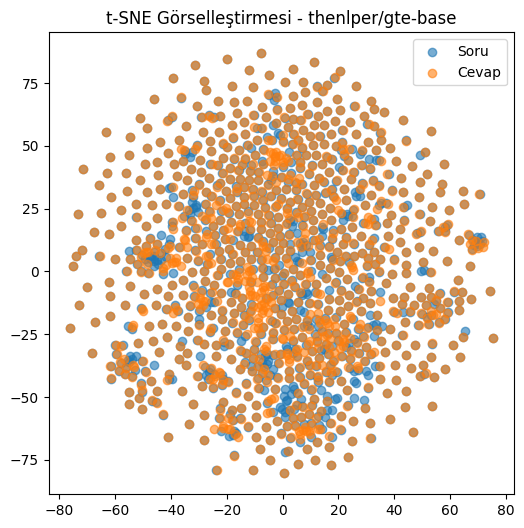


Model: jinaai/jina-embeddings-v3


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

jinaai/jina-embeddings-v3 Açı İstatistikleri (derece):
Min : 51.05°
Max : 80.01°
Ortalama: 65.58°
Medyan : 65.72°


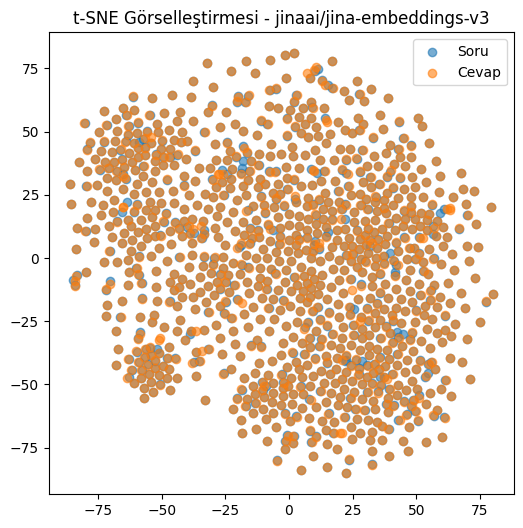


Model: BAAI/bge-m3
BAAI/bge-m3 Açı İstatistikleri (derece):
Min : 50.35°
Max : 75.41°
Ortalama: 65.33°
Medyan : 65.73°


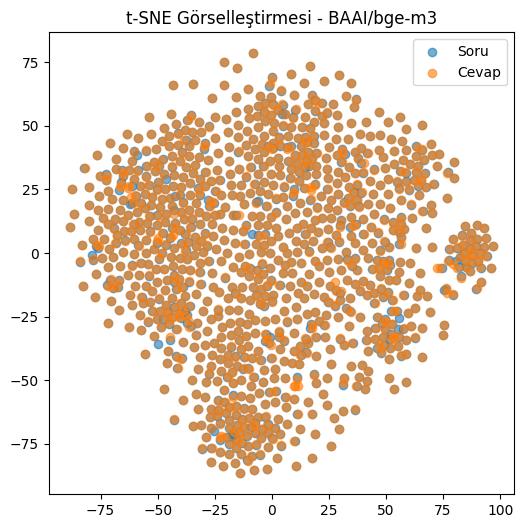


Model: dbmdz/bert-base-turkish-uncased


No sentence-transformers model found with name dbmdz/bert-base-turkish-uncased. Creating a new one with mean pooling.
c:\Users\User\OneDrive\Belgeler\OKUL\Kollektif\.venv\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--dbmdz--bert-base-turkish-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-deve

dbmdz/bert-base-turkish-uncased Açı İstatistikleri (derece):
Min : 26.01°
Max : 56.06°
Ortalama: 37.15°
Medyan : 36.52°


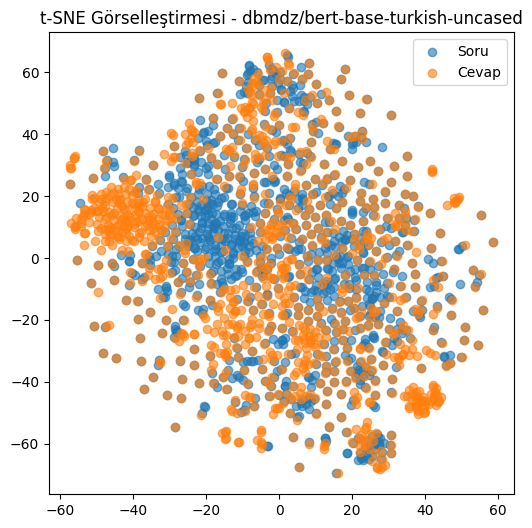


Model: intfloat/multilingual-e5-base


c:\Users\User\OneDrive\Belgeler\OKUL\Kollektif\.venv\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--intfloat--multilingual-e5-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


intfloat/multilingual-e5-base Açı İstatistikleri (derece):
Min : 22.37°
Max : 44.94°
Ortalama: 37.50°
Medyan : 37.56°


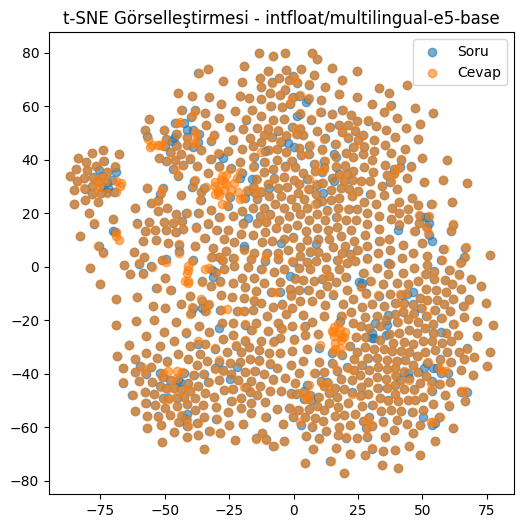

No sentence-transformers model found with name ytu-ce-cosmos/turkish-colbert. Creating a new one with mean pooling.



Model: ytu-ce-cosmos/turkish-colbert
ytu-ce-cosmos/turkish-colbert Açı İstatistikleri (derece):
Min : 21.33°
Max : 63.44°
Ortalama: 49.63°
Medyan : 50.29°


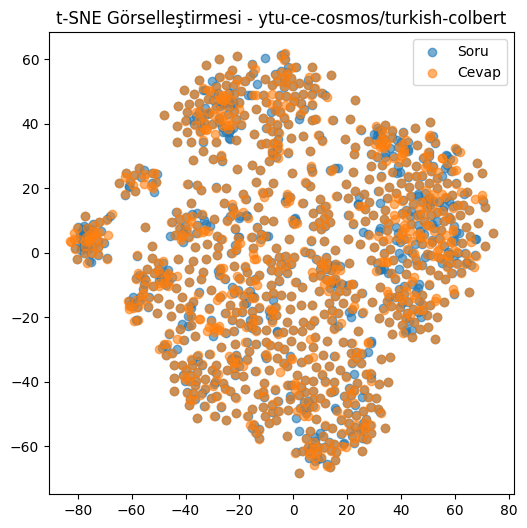

In [15]:
results = []
embedding_stats = []

for model_name in model_names:
    print(f"\nModel: {model_name}")
    try:
        # Modeli yükle
        model = SentenceTransformer(model_name, trust_remote_code=True, device='cuda')

        # On isleme
        if model_name == "ytu-ce-cosmos/turkish-colbert":
            questions_processed = [q.replace("I","ı").lower() for q in questions]
            answers_processed = [a.replace("I","ı").lower() for a in answers]
        else:
            questions_processed = questions
            answers_processed = answers
        
        # Embedding hesapla
        q_emb = model.encode(questions_processed, convert_to_numpy=True, show_progress_bar=False)
        a_emb = model.encode(answers_processed, convert_to_numpy=True, show_progress_bar=False)

        # Embedding istatistiklerini hesapla
        embedding_stats = plot_embedding_stats(embedding_stats, model_name, q_emb, a_emb)
        
        # Top-1 ve Top-5 skorlarını soru->cevap için hesapla
        top1_q2a = compute_topk_accuracy(q_emb, a_emb, k=1, distance_function=get_angle)
        top5_q2a = compute_topk_accuracy(q_emb, a_emb, k=5, distance_function=get_angle)
        
        # Top-1 ve Top-5 skorlarını cevap->soru için hesapla
        top1_a2q = compute_topk_accuracy(a_emb, q_emb, k=1, distance_function=get_angle)
        top5_a2q = compute_topk_accuracy(a_emb, q_emb, k=5, distance_function=get_angle)
        
        # Sonuçları kaydet
        results.append({
            "model": model_name,
            "top1_q2a": top1_q2a,
            "top5_q2a": top5_q2a,
            "top1_a2q": top1_a2q,
            "top5_a2q": top5_a2q
        })
        
        # t-SNE çiz
        plot_tsne(q_emb, a_emb, model_name)

    except Exception as e:
        print(f"Model yüklenirken veya hesap yapılırken hata oluştu: {e}")

In [16]:
results

[{'model': 'thenlper/gte-base',
  'top1_q2a': 0.929,
  'top5_q2a': 0.973,
  'top1_a2q': 0.938,
  'top5_a2q': 0.977},
 {'model': 'jinaai/jina-embeddings-v3',
  'top1_q2a': 0.979,
  'top5_q2a': 0.993,
  'top1_a2q': 0.985,
  'top5_a2q': 0.996},
 {'model': 'BAAI/bge-m3',
  'top1_q2a': 0.98,
  'top5_q2a': 0.997,
  'top1_a2q': 0.986,
  'top5_a2q': 0.994},
 {'model': 'dbmdz/bert-base-turkish-uncased',
  'top1_q2a': 0.676,
  'top5_q2a': 0.754,
  'top1_a2q': 0.845,
  'top5_a2q': 0.93},
 {'model': 'intfloat/multilingual-e5-base',
  'top1_q2a': 0.961,
  'top5_q2a': 0.983,
  'top1_a2q': 0.987,
  'top5_a2q': 0.994},
 {'model': 'ytu-ce-cosmos/turkish-colbert',
  'top1_q2a': 0.914,
  'top5_q2a': 0.95,
  'top1_a2q': 0.933,
  'top5_a2q': 0.979}]

In [17]:
embedding_stats

[{'model': 'thenlper/gte-base',
  'Min': 18.584354300126314,
  'Max': 40.32153423306179,
  'Ortalama': 32.1198415451887,
  'Medyan': 32.08707340439715},
 {'model': 'jinaai/jina-embeddings-v3',
  'Min': 51.052020023675624,
  'Max': 80.0106701245725,
  'Ortalama': 65.58119551127633,
  'Medyan': 65.72191387917246},
 {'model': 'BAAI/bge-m3',
  'Min': 50.34598084608764,
  'Max': 75.41244332822369,
  'Ortalama': 65.32532651413034,
  'Medyan': 65.73272376534278},
 {'model': 'dbmdz/bert-base-turkish-uncased',
  'Min': 26.008862955279692,
  'Max': 56.062254032751376,
  'Ortalama': 37.15042552591189,
  'Medyan': 36.51962611610069},
 {'model': 'intfloat/multilingual-e5-base',
  'Min': 22.37383041781067,
  'Max': 44.94453914196671,
  'Ortalama': 37.5029031174605,
  'Medyan': 37.55764239388395},
 {'model': 'ytu-ce-cosmos/turkish-colbert',
  'Min': 21.32529415335773,
  'Max': 63.438585935937326,
  'Ortalama': 49.628973305663706,
  'Medyan': 50.29108456177668}]

In [18]:
# Tum modellerin karsilastirmali sonuclari
df_results = pd.DataFrame(results)
print("\nTop-1 ve Top-5:")
print(df_results)


Top-1 ve Top-5:
                             model  top1_q2a  top5_q2a  top1_a2q  top5_a2q
0                thenlper/gte-base     0.929     0.973     0.938     0.977
1        jinaai/jina-embeddings-v3     0.979     0.993     0.985     0.996
2                      BAAI/bge-m3     0.980     0.997     0.986     0.994
3  dbmdz/bert-base-turkish-uncased     0.676     0.754     0.845     0.930
4    intfloat/multilingual-e5-base     0.961     0.983     0.987     0.994
5    ytu-ce-cosmos/turkish-colbert     0.914     0.950     0.933     0.979


In [19]:
# Tum modellerin karsilastirmali sonuclari
df_embedding_stats = pd.DataFrame(embedding_stats)
print("\nEmbedding İstatistikleri:")
print(df_embedding_stats)


Embedding İstatistikleri:
                             model        Min        Max   Ortalama     Medyan
0                thenlper/gte-base  18.584354  40.321534  32.119842  32.087073
1        jinaai/jina-embeddings-v3  51.052020  80.010670  65.581196  65.721914
2                      BAAI/bge-m3  50.345981  75.412443  65.325327  65.732724
3  dbmdz/bert-base-turkish-uncased  26.008863  56.062254  37.150426  36.519626
4    intfloat/multilingual-e5-base  22.373830  44.944539  37.502903  37.557642
5    ytu-ce-cosmos/turkish-colbert  21.325294  63.438586  49.628973  50.291085


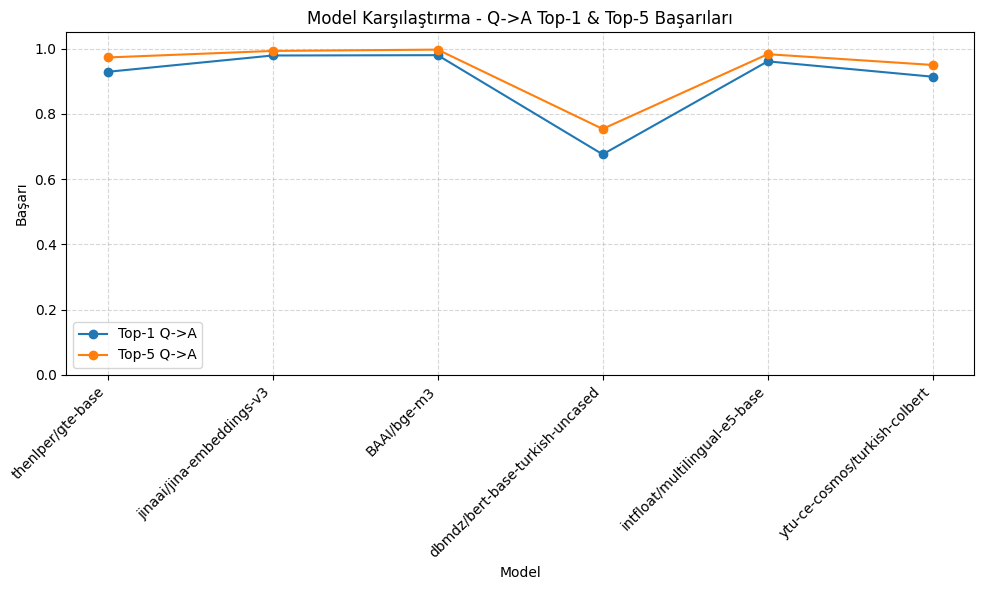

In [20]:
plt.figure(figsize=(10, 6))
x = np.arange(len(df_results))  # model index

plt.plot(x, df_results["top1_q2a"], marker="o", label="Top-1 Q->A")
plt.plot(x, df_results["top5_q2a"], marker="o", label="Top-5 Q->A")

plt.xticks(x, df_results["model"], rotation=45, ha="right")
plt.ylim([0, 1.05])
plt.title("Model Karşılaştırma - Q->A Top-1 & Top-5 Başarıları")
plt.ylabel("Başarı")
plt.xlabel("Model")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

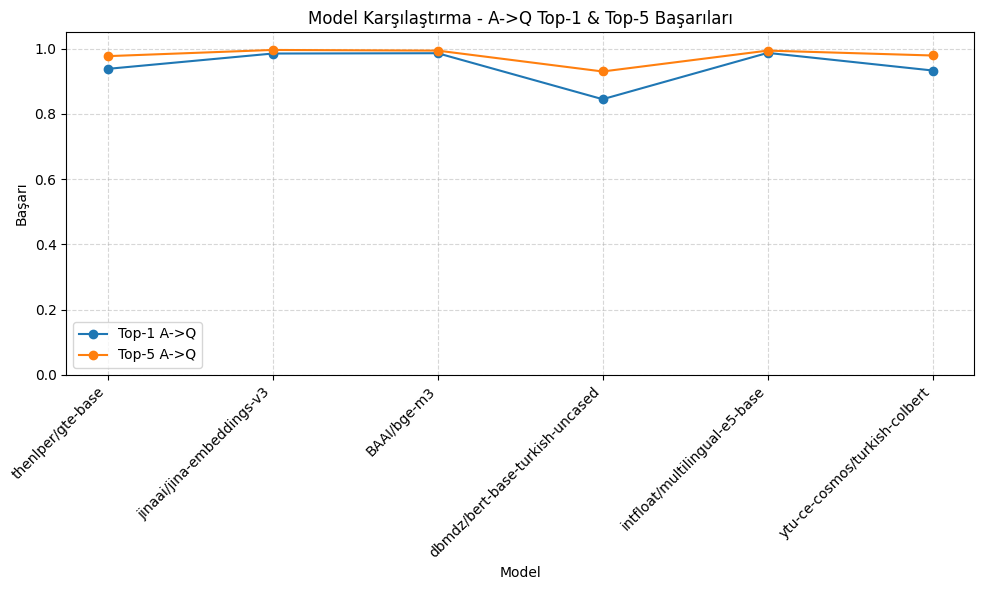

In [21]:
plt.figure(figsize=(10, 6))
x = np.arange(len(df_results))

plt.plot(x, df_results["top1_a2q"], marker="o", label="Top-1 A->Q")
plt.plot(x, df_results["top5_a2q"], marker="o", label="Top-5 A->Q")

plt.xticks(x, df_results["model"], rotation=45, ha="right")
plt.ylim([0, 1.05])
plt.title("Model Karşılaştırma - A->Q Top-1 & Top-5 Başarıları")
plt.ylabel("Başarı")
plt.xlabel("Model")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

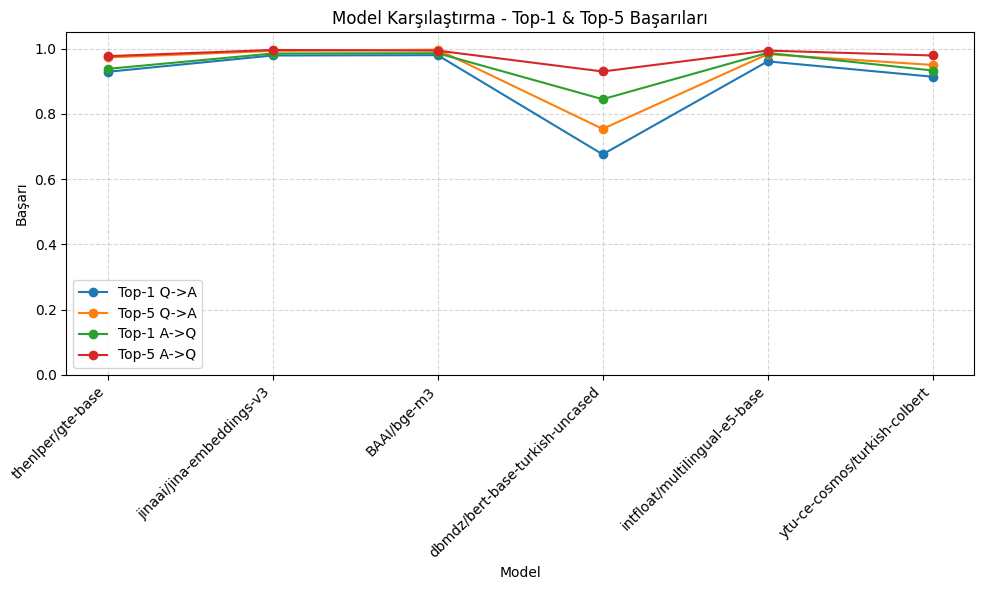

In [22]:
plt.figure(figsize=(10, 6))
x = np.arange(len(df_results))  # model index

plt.plot(x, df_results["top1_q2a"], marker="o", label="Top-1 Q->A")
plt.plot(x, df_results["top5_q2a"], marker="o", label="Top-5 Q->A")
plt.plot(x, df_results["top1_a2q"], marker="o", label="Top-1 A->Q")
plt.plot(x, df_results["top5_a2q"], marker="o", label="Top-5 A->Q")

plt.xticks(x, df_results["model"], rotation=45, ha="right")
plt.ylim([0, 1.05])
plt.title("Model Karşılaştırma - Top-1 & Top-5 Başarıları")
plt.ylabel("Başarı")
plt.xlabel("Model")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()